# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [ ]:
# модель будет обучаться долго - рекомендую сохранять промежуточные версии. В колабе это можно делать примерно так
from google.colab import drive
drive.mount('/content/drive')
#теперь для сохранения файлов вам доступна директория /content/drive

Mounted at /content/drive


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
dl = "18UTENzuzvwViI0c9uELD4eN4Z9W0H83b"
gdd.download_file_from_google_drive(file_id=dl,
                                    dest_path='./img_align_celeba.zip',
                                    unzip=True)

Unzipping...Done.


In [ ]:
!mkdir "tmp"

In [ ]:
!cp -R "/content/img_align_celeba" "/content/tmp/"

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms, datasets

In [ ]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64


In [ ]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])
 
dataset = datasets.ImageFolder(root='/content/tmp/',
                           transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataset[0][0].shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


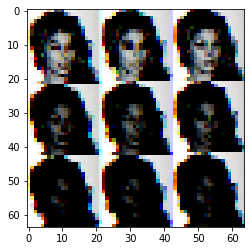

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(dataset[5][0].cpu().detach().numpy().reshape((64,64,3)))

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [ ]:
device = torch.device('cuda:0')
torch.cuda.empty_cache()

In [ ]:
num_channels = 3
latent_size = 100
base_size = 32

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.LeakyReLU(0.2,inplace=True),
    
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.LeakyReLU(0.2,inplace=True),
    
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.LeakyReLU(0.2,inplace=True),
    
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.LeakyReLU(0.2,inplace=True),
    
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.Tanh()
    # (num_channels) x 64 x 64
).to(device)

In [ ]:
z = torch.randn(1,latent_size, 1, 1).to(device)

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d... Параметры сверток можно поставить в обратную сторону.

In [ ]:
base_size = base_size//4
D = nn.Sequential(
    nn.Conv2d(num_channels, base_size, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(base_size, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(base_size * 2, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(base_size * 4, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(base_size * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
).to(device)

В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [ ]:
# # если мы предварительно сохраняли модели и хотим запустить их, то это вот так
# D.load_state_dict(torch.load('/content/drive/MyDrive/D.pt')) # можно и другую директорию, но вот это прямо внутри вашего гугл диска
# G.load_state_dict(torch.load('/content/drive/MyDrive/G.pt'))

In [ ]:
num_epochs = 25
learning_rate = 0.0002

beta1 = 0.5
img_list = []
G_losses = []
D_losses = []

optim_D = torch.optim.SGD(D.parameters(), lr=learning_rate) # ваш любимый оптимизатор параметров дискриминатора
optim_G = torch.optim.Adam(G.parameters(), lr=learning_rate,betas=(beta1, 0.999)) # ваш любимый оптимизатор параметров генератора

criterion = nn.BCELoss()

for epoch in range(num_epochs):
    iters = 0

    for (data, _) in loader:
        # Обучать GANы всегда долго, и мы хотим по максимуму переиспользовать вычисления

        # 1. Обучим D: max log(D(x)) + log(1 - D(G(z)))
        
        D.zero_grad()
        
        # a) Распакуйте данные на нужный девайс
        data = data.to(device)

        #    Прогоните через сеть
        out = D(data)

        #    Сгенерируйте вектор из единичек (ответы для реальных сэмплов)
        if iters%100:
            target = torch.FloatTensor(out.size()).uniform_(0.7, 1).to(device)
        else:
            target = torch.FloatTensor(out.size()).uniform_(0, 0.3).to(device)

        #    Посчитайте лосс, сделайте .backward()
        D_loss = criterion(out, target)
        D_loss.backward()

        # b) Посэмплите из torch.randn
        latent_noise = torch.normal(3, 1, size=((out.size()[0], latent_size, 1, 1))).to(device)

        #    Прогоните этот шум через генератор
        out = G(latent_noise)

        #    detach-ните (нам не нужно считать градиенты G)
        out = out.detach()

        #    Прогоните через дискриминатор
        out_D = D(out)
        
        #    Сгенерите вектор из нулей (ответы для фейков)
        target = torch.FloatTensor(size=(out_D.size())).uniform_(0, 0.3).to(device)

        #    Посчитайте лосс, сделайте backward (он сложится, а не перезапишется)
        D_loss = criterion(out_D, target)
        D_loss.backward(retain_graph=True)

        #    Также можно сначала сгенерировать данные, а потом собрать из двух частей батч,
        #    В котором первая половина лэйблов будет нулями, а вторая -- единицами
        
        optim_D.step()
        

        # 2. Обучим G: max log(D(G(z)))

        G.zero_grad()
        # Тут проще:
        #    Получим вектор неправильных ответов -- вектор единиц (мы ведь хотим, чтобы D считал их неправильными)
        target = torch.FloatTensor(out_D.size()).uniform_(0.7, 1).to(device)

        #    Прогоним ранее сгенерированные картинки через D
        out = D(out)

        #    Посчитаем лосc, сделаем .backward()
        G_loss = criterion(out, target)
        G_loss.backward()
        
        optim_G.step()

        # Раз в сколько-то итераций логгируем лосс
        if iters % 10 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {iters/len(loader)}')
            print(f'  G loss: {G_loss}')
            print(f'  D loss: {D_loss}')
            print()
            
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if iters % 50 == 0:
            # вы на этом батче уже генерировали какие-то картинки: просто добавьте их в список
            
            # а вот тут сохраняем
            torch.save(D.state_dict(), '/content/drive/My Drive/D.pt')
            torch.save(G.state_dict(), '/content/drive/My Drive/G.pt')
        iters += 1

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# распечатайте ваши картинки

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.

In [ ]:
# посмотрите на данные (вы писали нужный код в колоризации)
# ...
import matplotlib.pyplot as plt
def show_img(sample):
    img = sample
    # img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))

    f = plt.figure(figsize=(2,3))
    f.add_subplot(1,1,1)
    plt.imshow(npimg_color)
G.eval()
z = torch.randn(1,latent_size, 1, 1).to(device)
show_img(G(z).cpu().detach()[0])